In [ ]:
from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map


sns.set_theme()

# %load_ext lab_black

In [ ]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved


params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("../../_static/img/tutorials/"),
)
params

# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exist
params.savefig_folder.mkdir(parents=True, exist_ok=True)

In [ ]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

In [ ]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")


class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))


class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # Find the indices where the Q-value equals the maximum value
            # Choose a random action from the indices where the Q-value is maximum
            max_ids = np.where(qtable[state, :] == max(qtable[state, :]))[0]
            action = rng.choice(max_ids)
        return action

Action size: 4
State size: 25


In [ ]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

In [ ]:
def run_env(alpha, gamma, epsilon):
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

In [ ]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(order="F"),
            "Steps": steps.flatten(order="F"),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

In [ ]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [ ]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [ ]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

Map size: 4x4


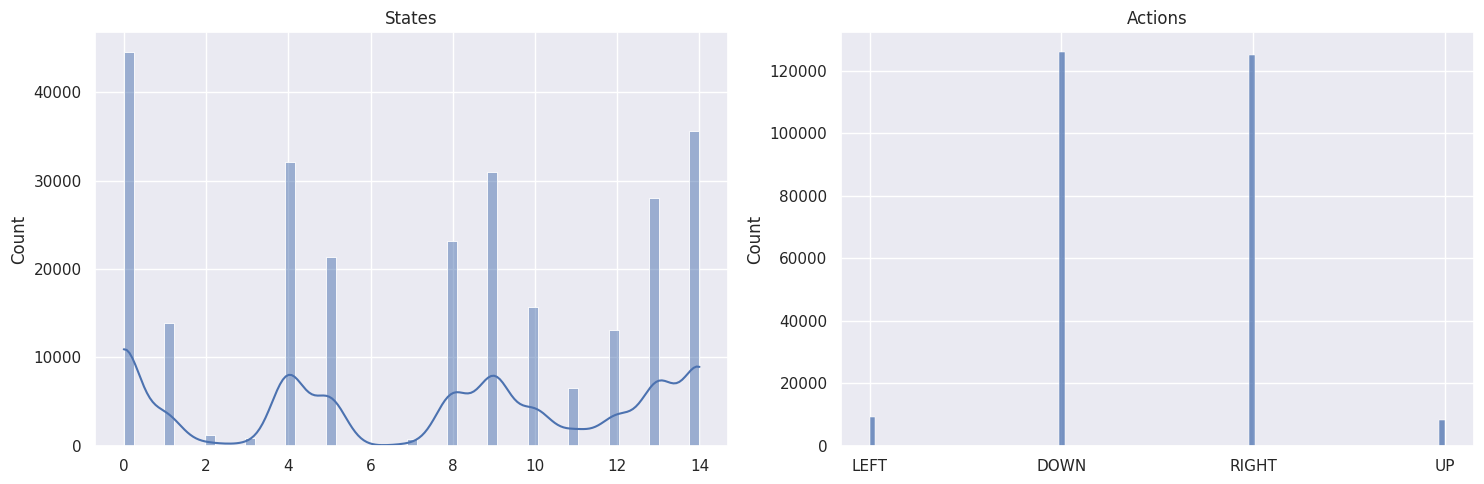

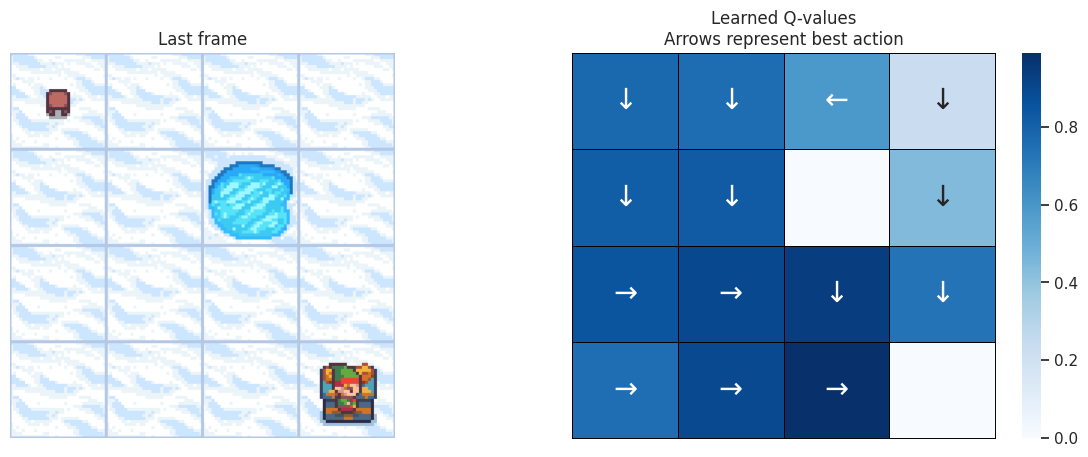

Map size: 7x7


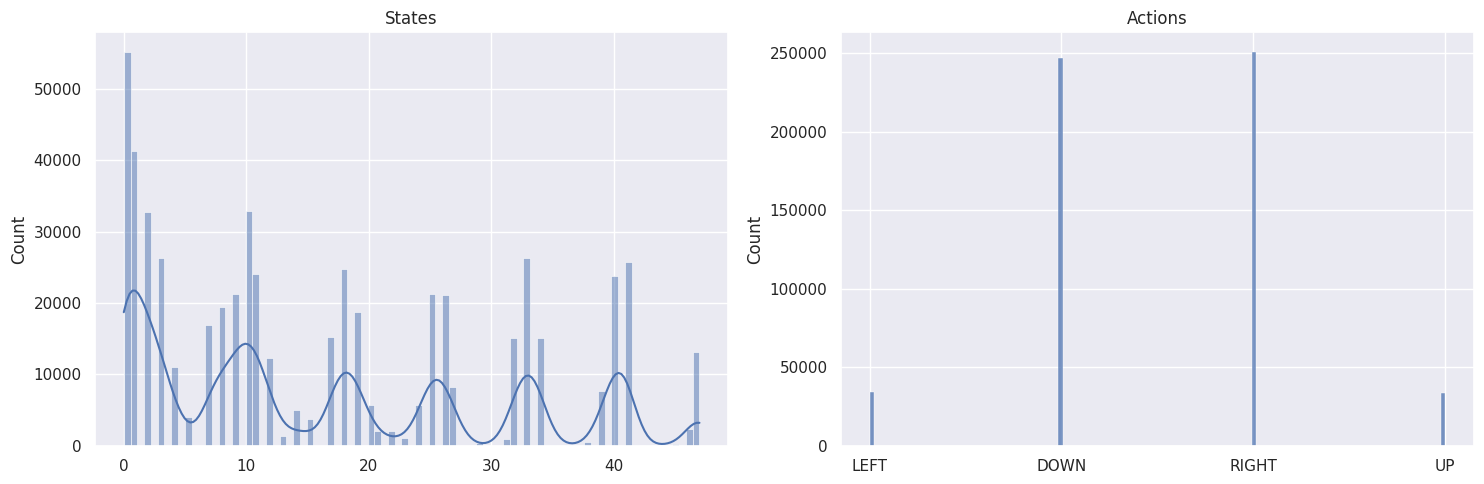

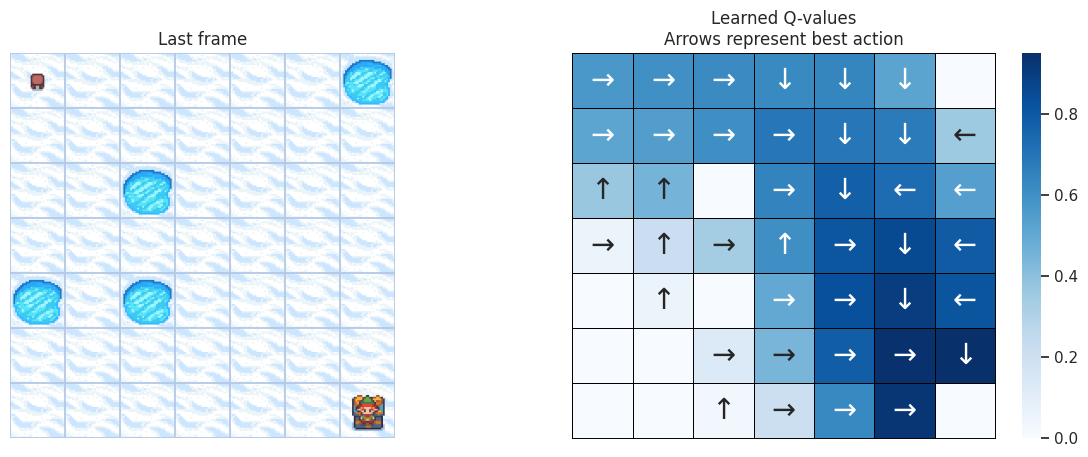

Map size: 9x9


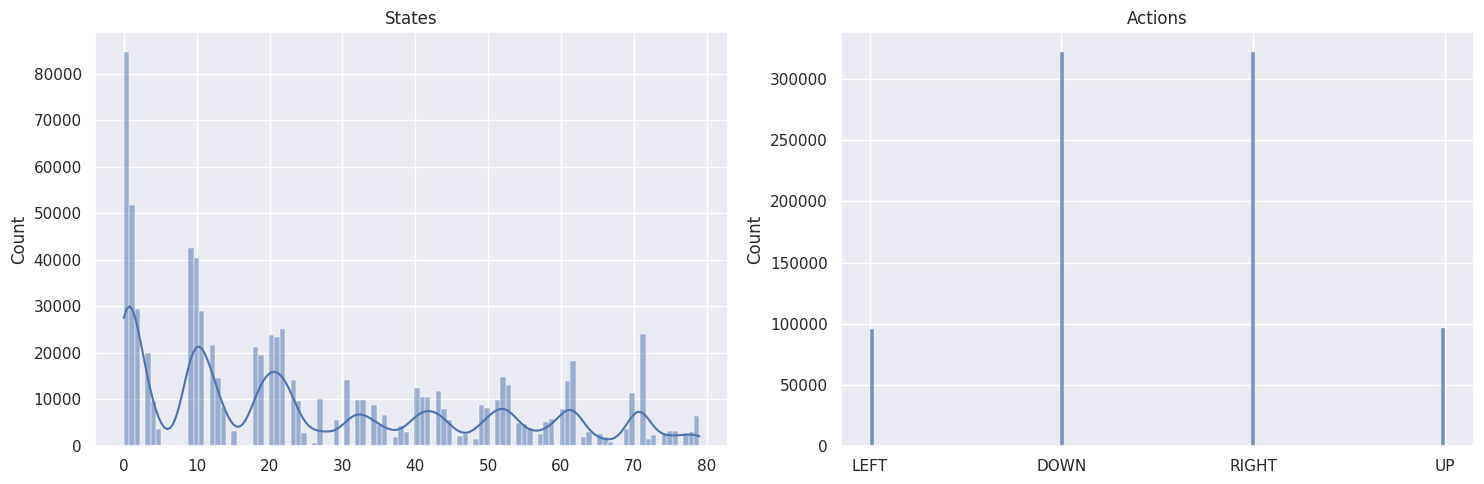

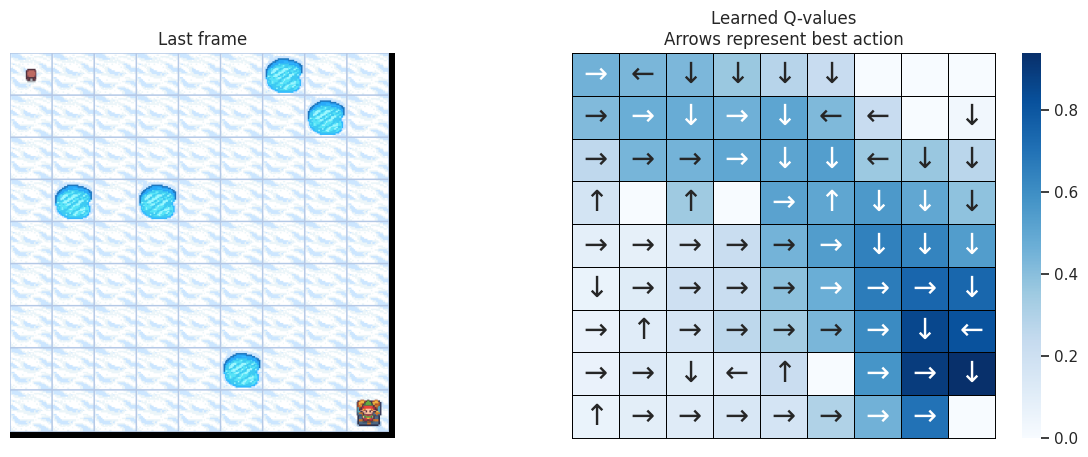

Map size: 11x11


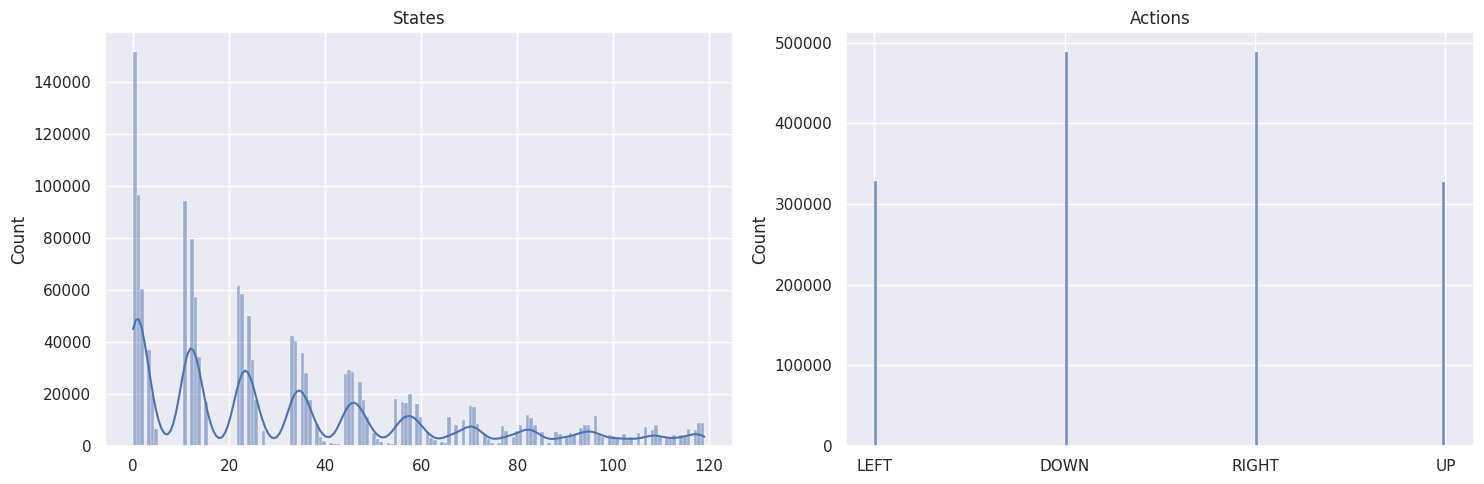

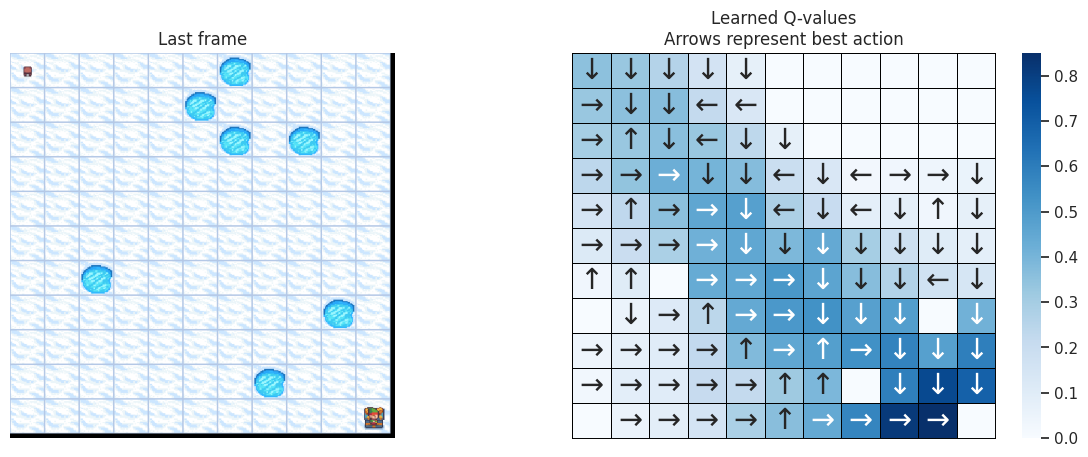

In [ ]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env(params.learning_rate, params.gamma, params.epsilon)

    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )
    plot_q_values_map(qtable, env, map_size)

    env.close()

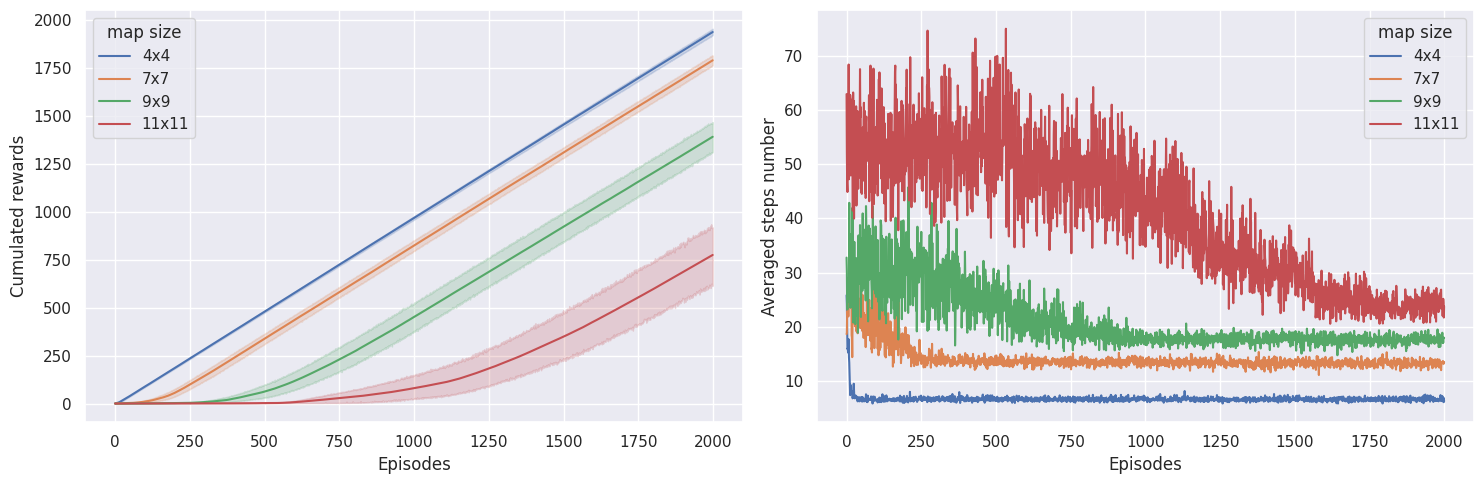

In [ ]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


plot_steps_and_rewards(res_all, st_all)

Running with alpha=0.1, gamma=0.8, epsilon=0.01


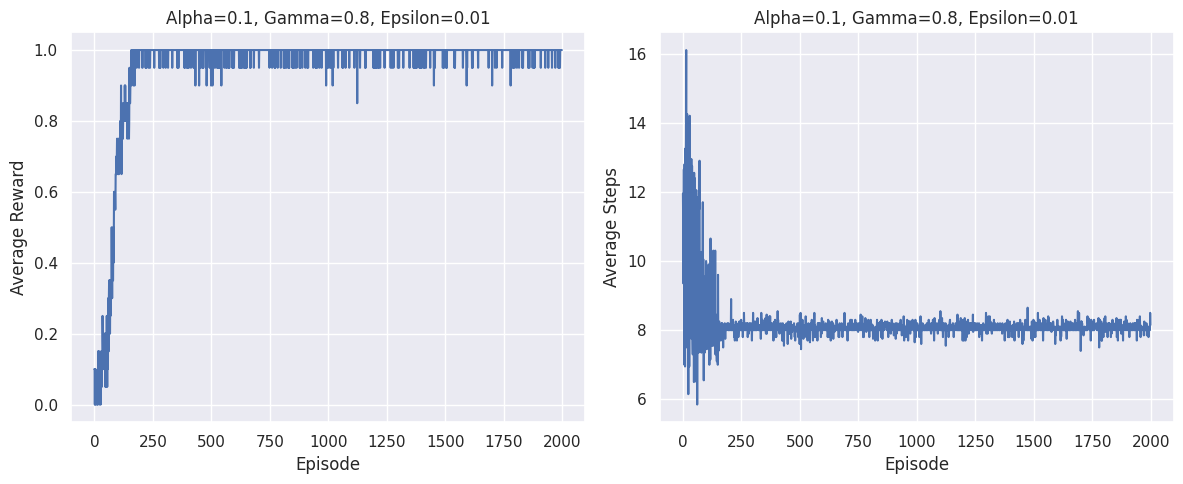

Running with alpha=0.1, gamma=0.8, epsilon=0.1


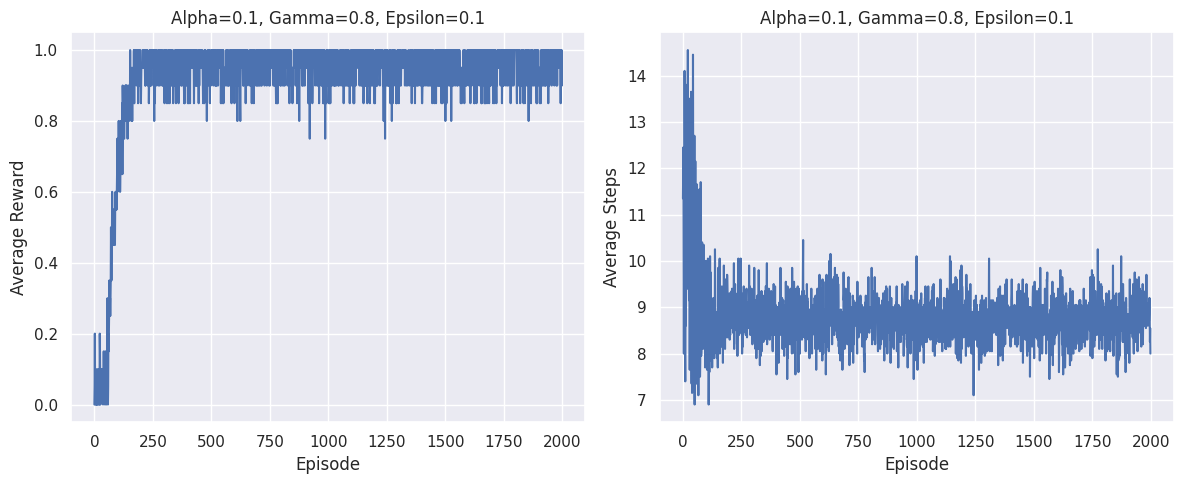

Running with alpha=0.1, gamma=0.8, epsilon=0.5


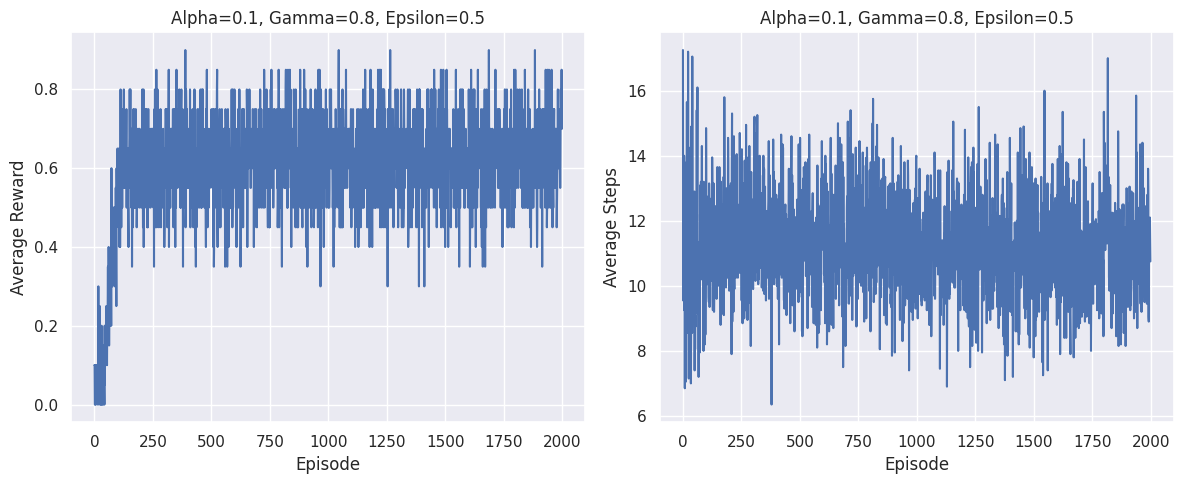

Running with alpha=0.1, gamma=0.9, epsilon=0.01


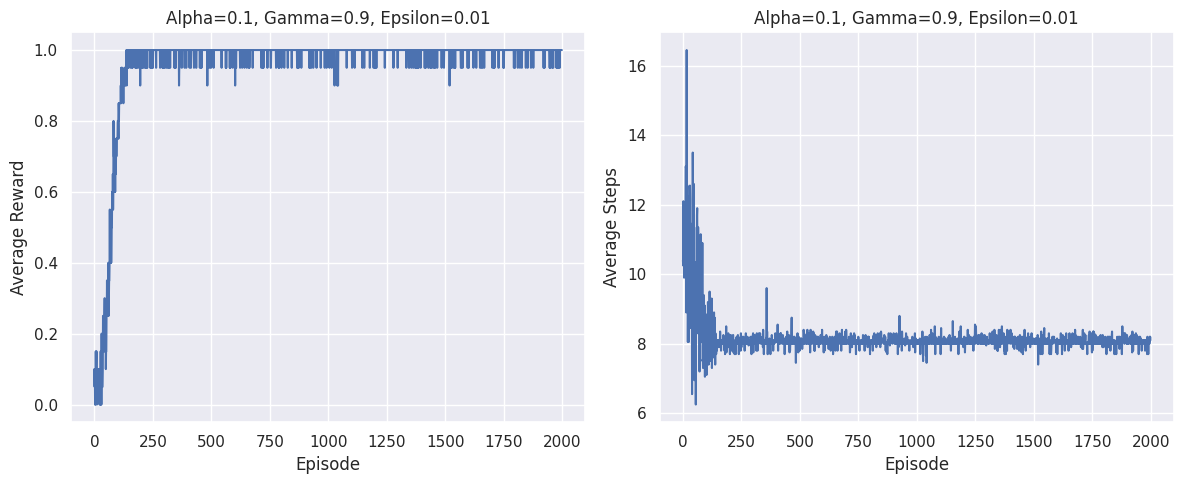

Running with alpha=0.1, gamma=0.9, epsilon=0.1


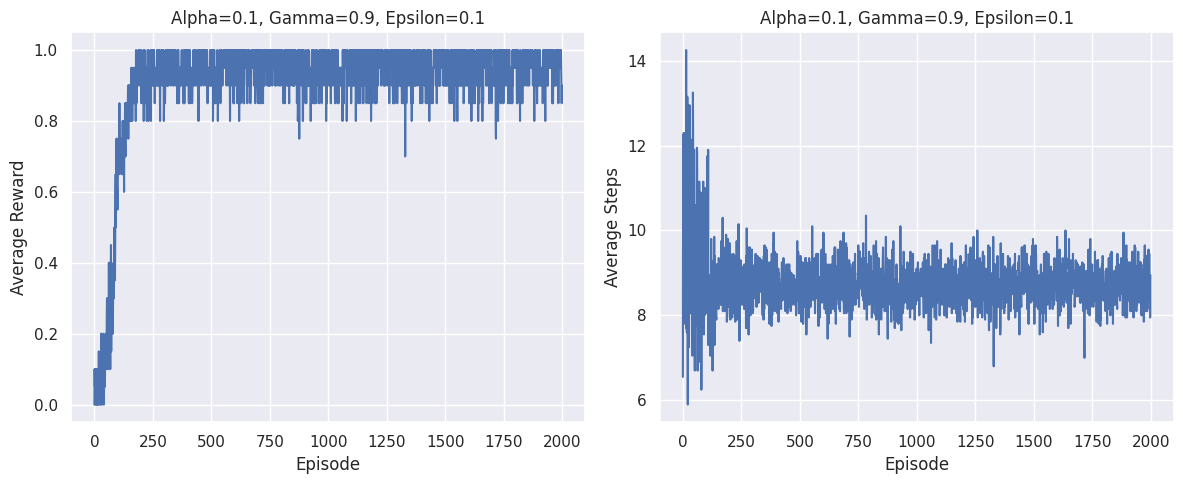

Running with alpha=0.1, gamma=0.9, epsilon=0.5


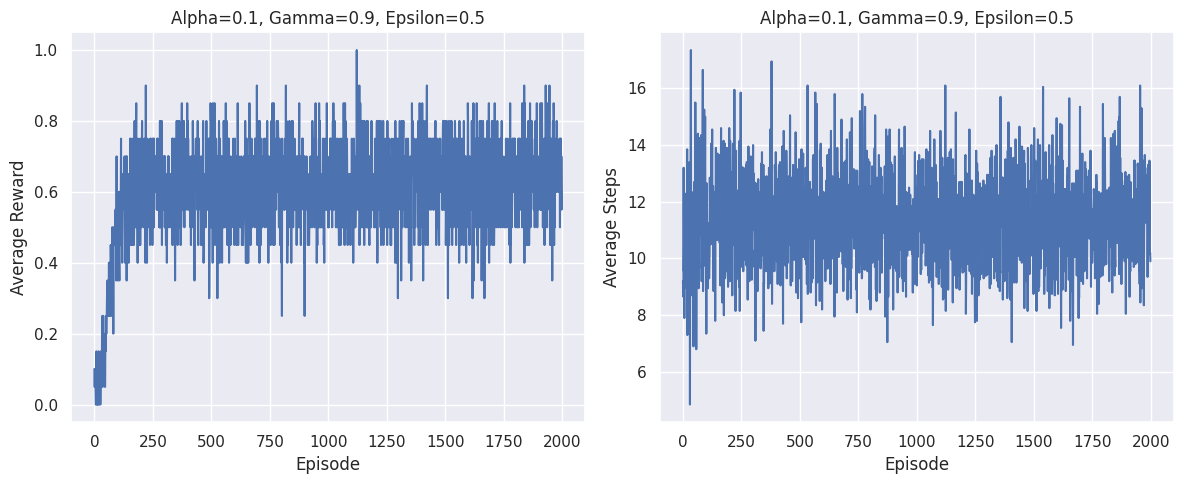

Running with alpha=0.1, gamma=0.99, epsilon=0.01


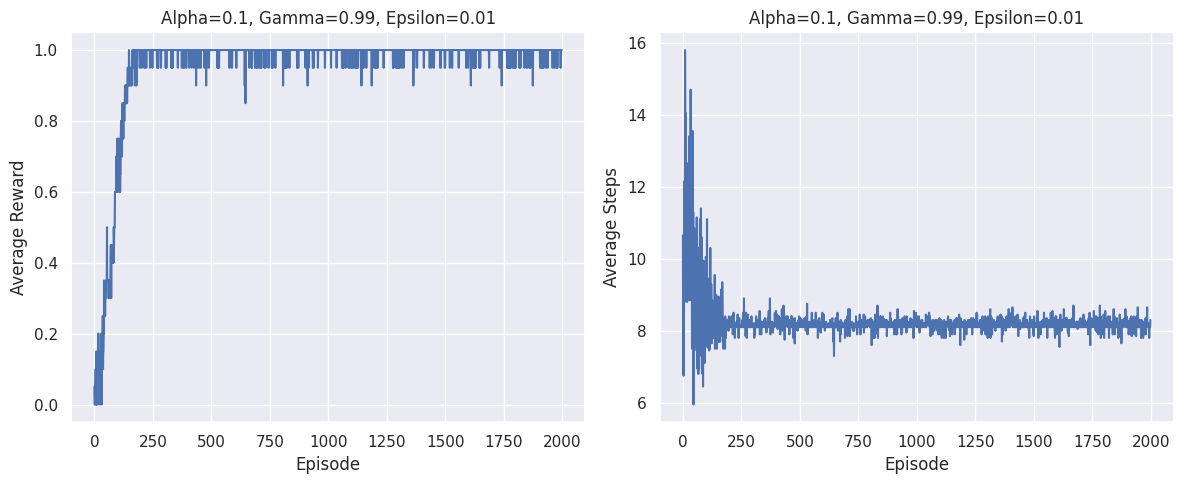

Running with alpha=0.1, gamma=0.99, epsilon=0.1


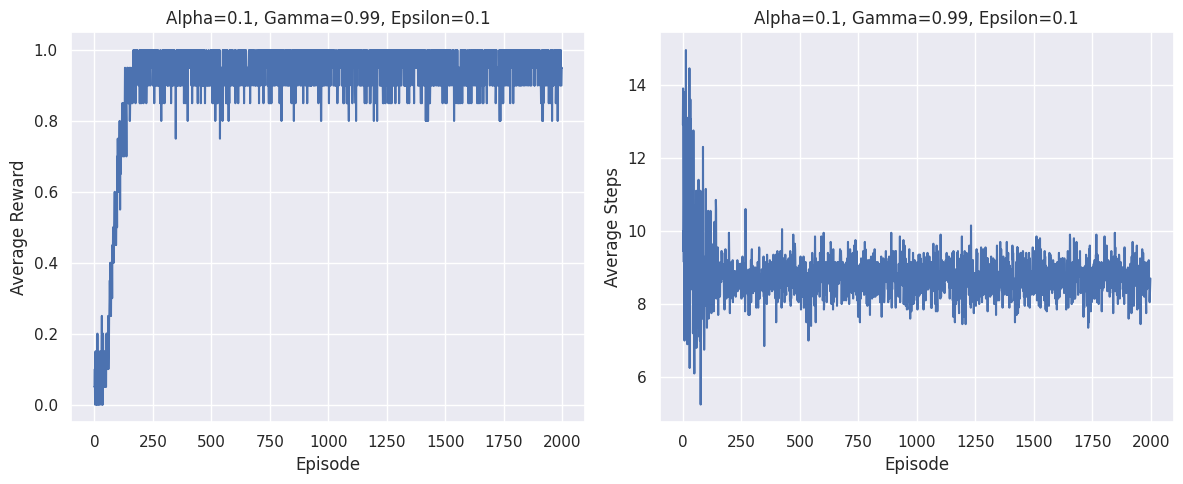

Running with alpha=0.1, gamma=0.99, epsilon=0.5


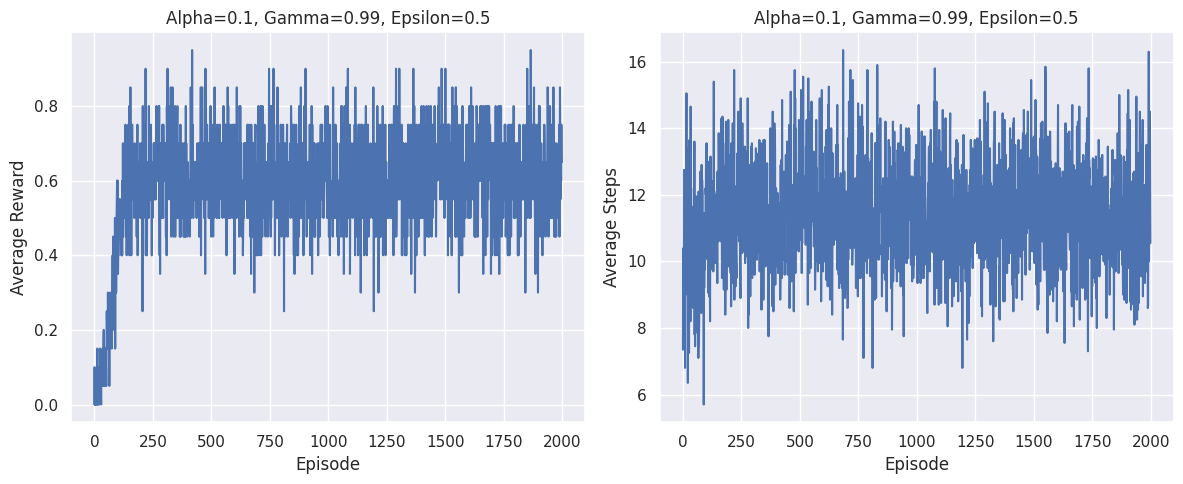

Running with alpha=0.5, gamma=0.8, epsilon=0.01


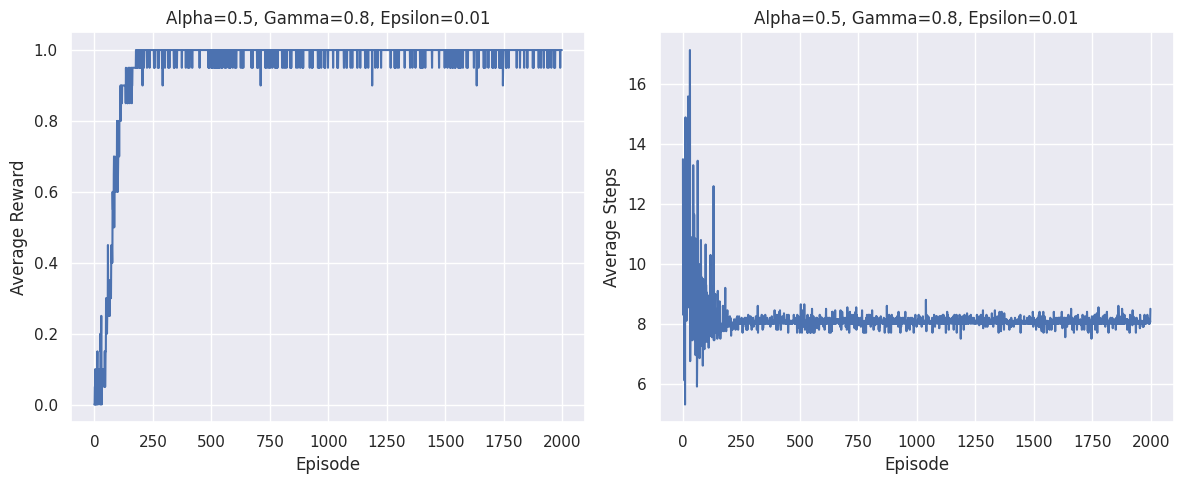

Running with alpha=0.5, gamma=0.8, epsilon=0.1


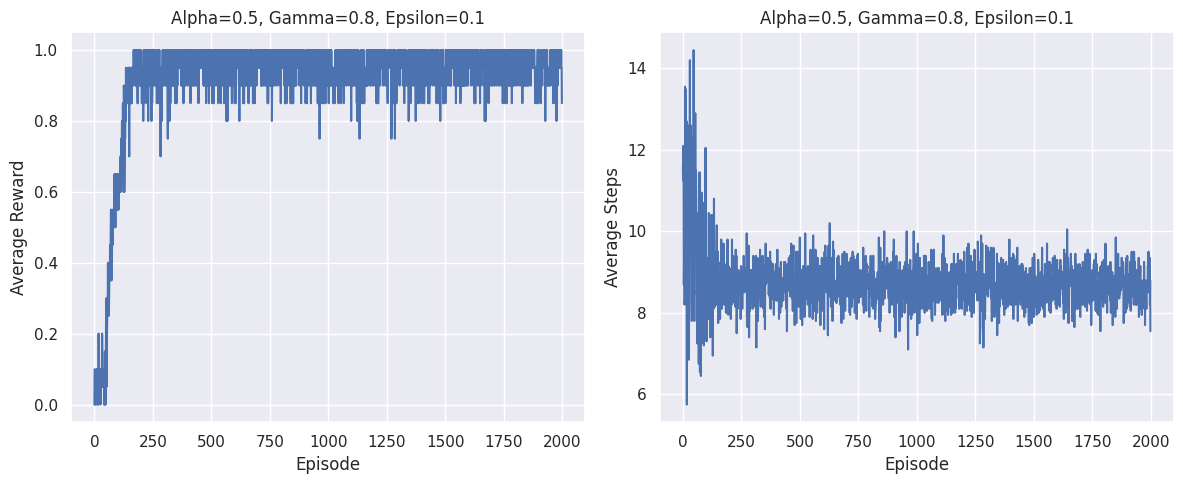

Running with alpha=0.5, gamma=0.8, epsilon=0.5


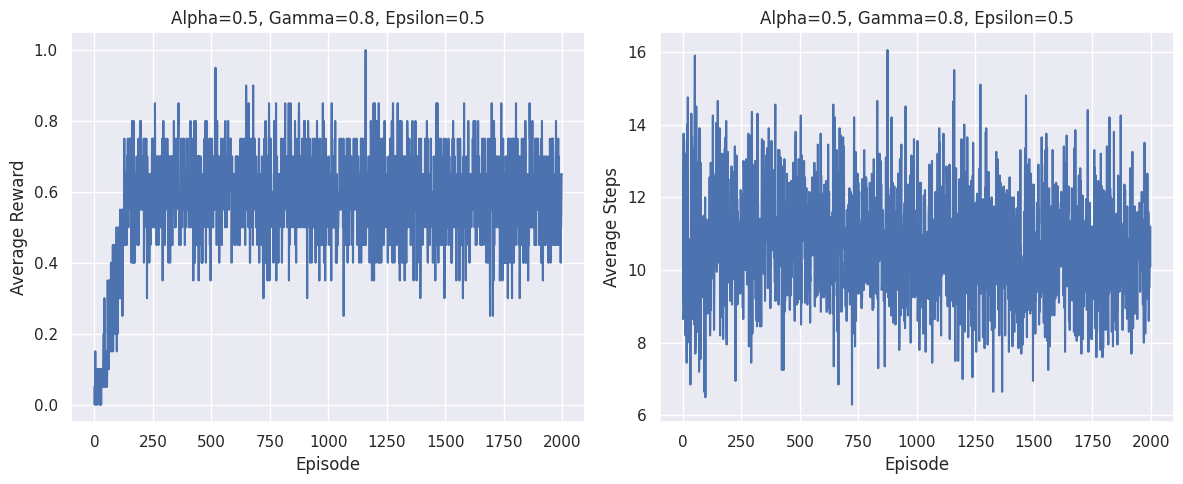

Running with alpha=0.5, gamma=0.9, epsilon=0.01


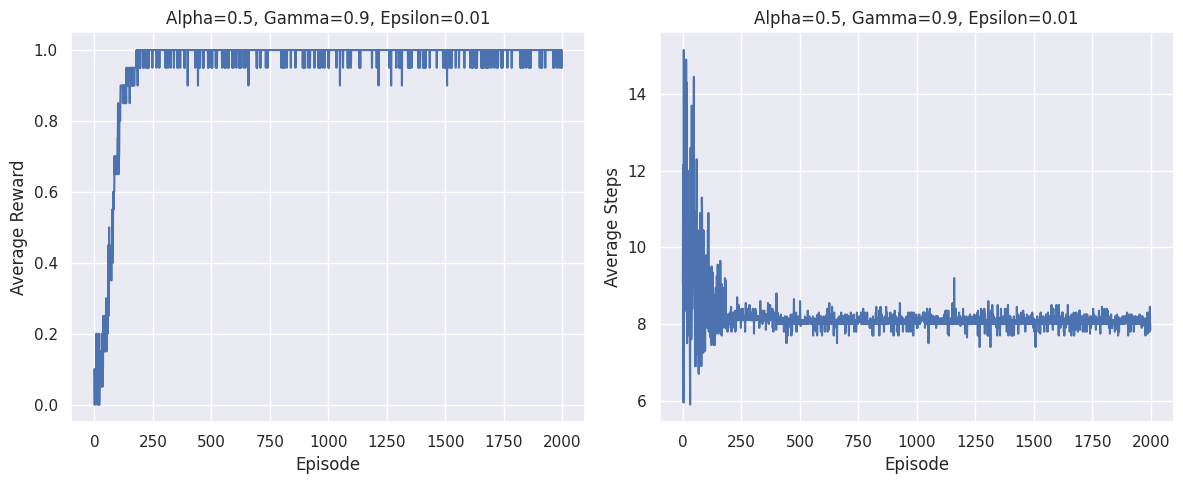

Running with alpha=0.5, gamma=0.9, epsilon=0.1


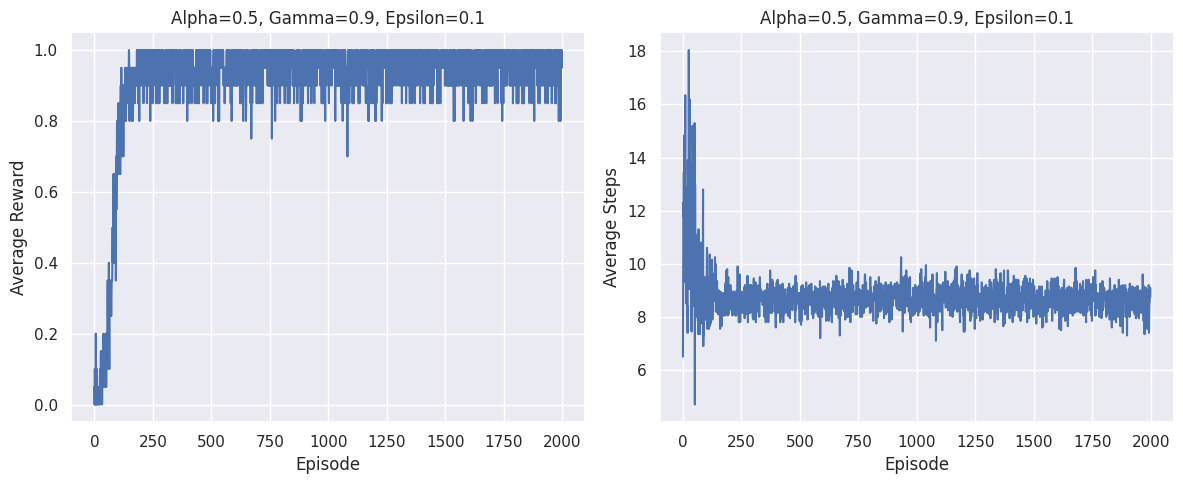

Running with alpha=0.5, gamma=0.9, epsilon=0.5


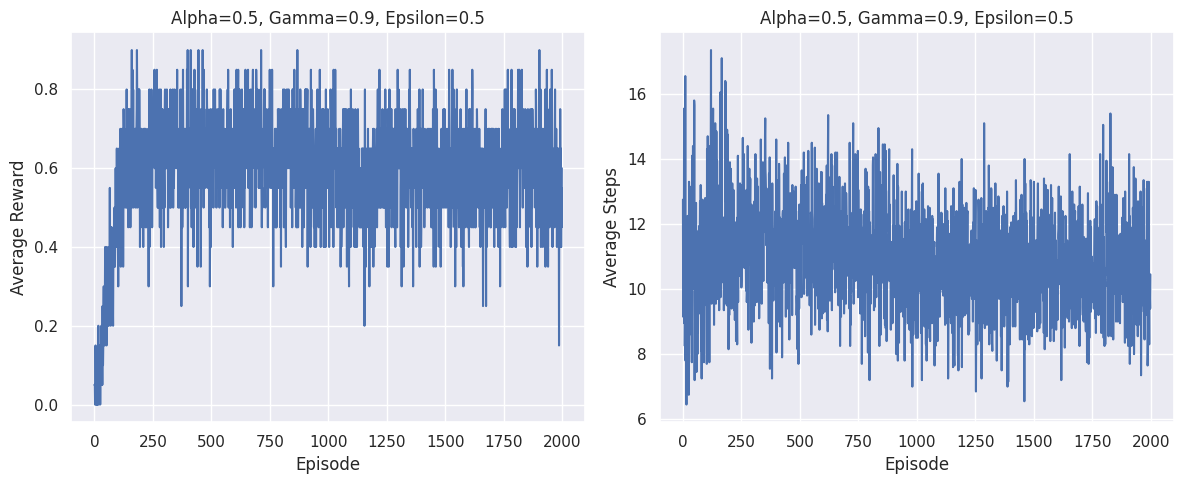

Running with alpha=0.5, gamma=0.99, epsilon=0.01


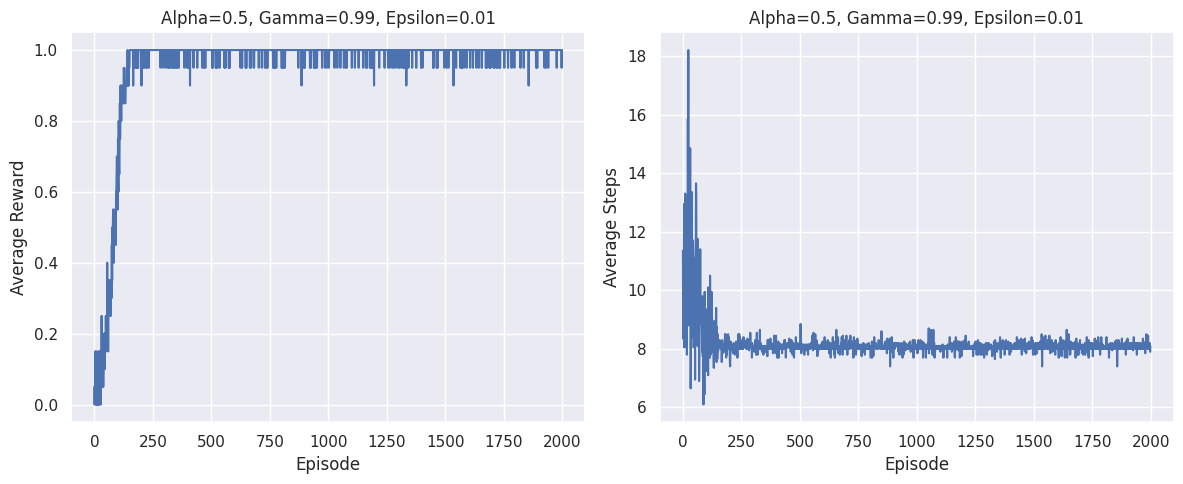

Running with alpha=0.5, gamma=0.99, epsilon=0.1


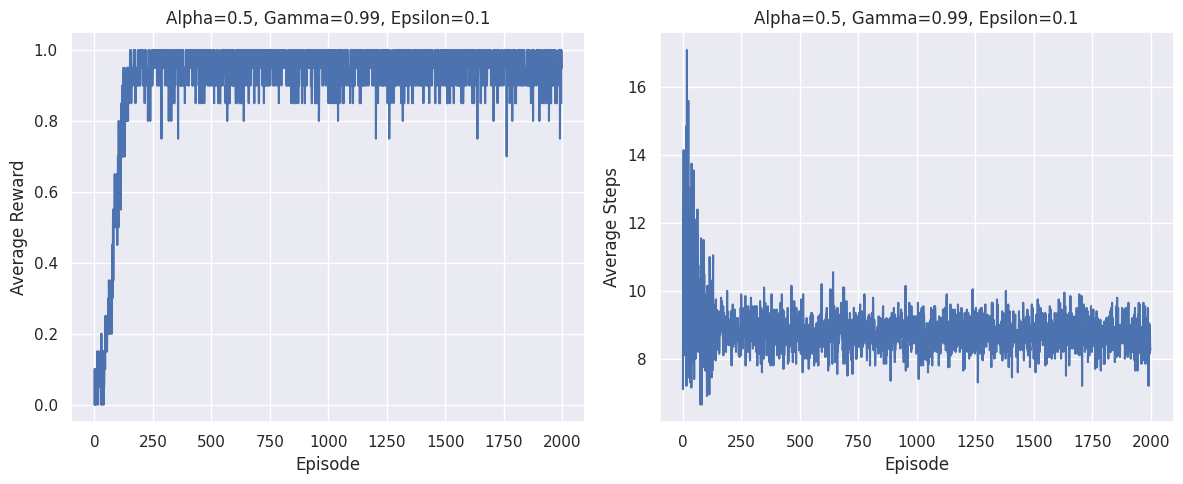

Running with alpha=0.5, gamma=0.99, epsilon=0.5


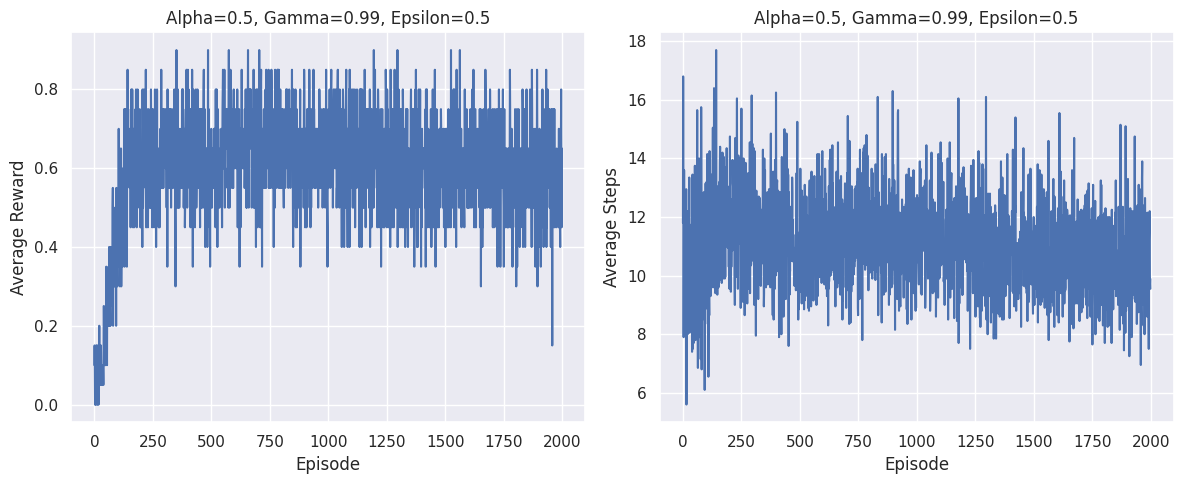

Running with alpha=0.9, gamma=0.8, epsilon=0.01


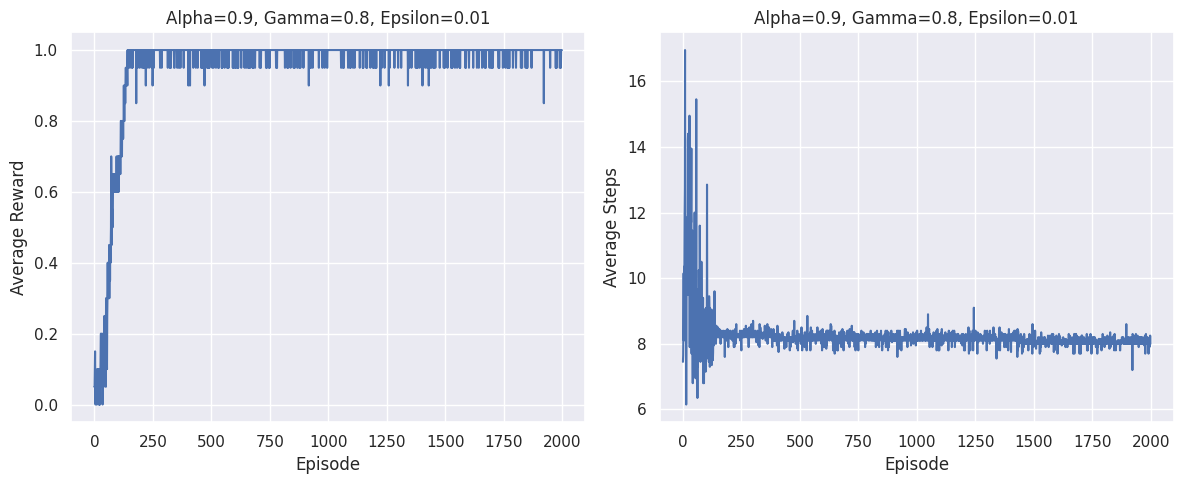

Running with alpha=0.9, gamma=0.8, epsilon=0.1


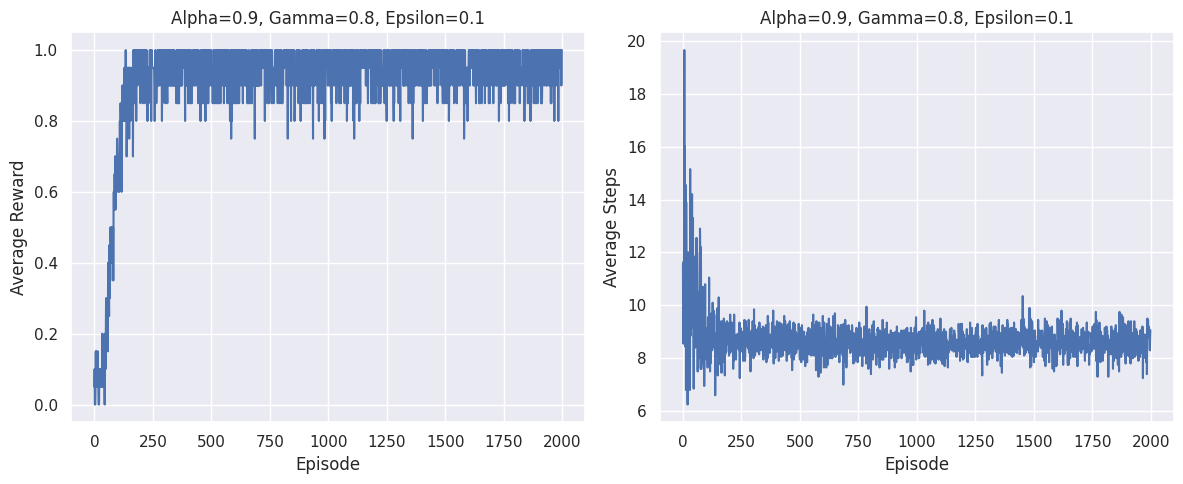

Running with alpha=0.9, gamma=0.8, epsilon=0.5


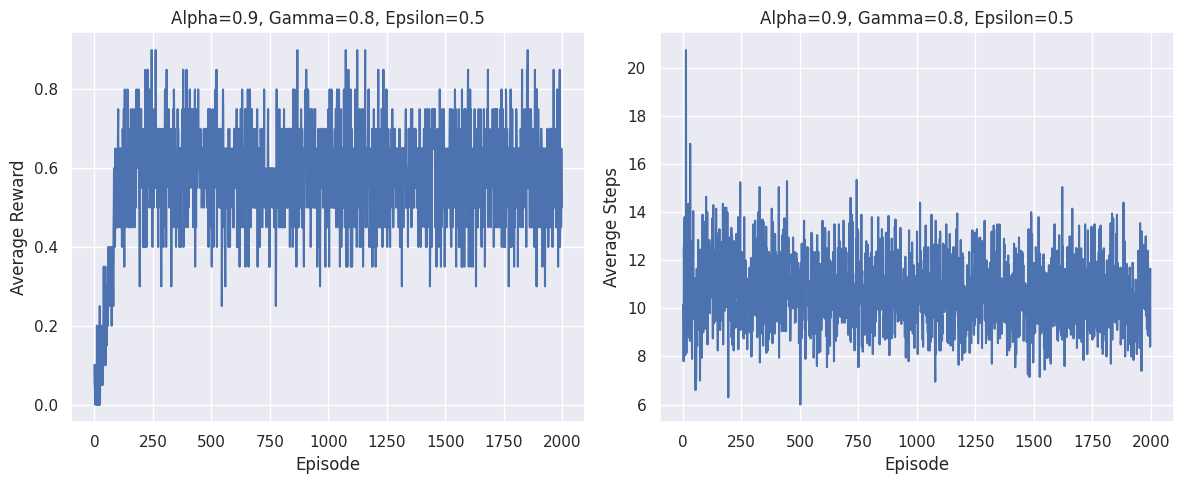

Running with alpha=0.9, gamma=0.9, epsilon=0.01


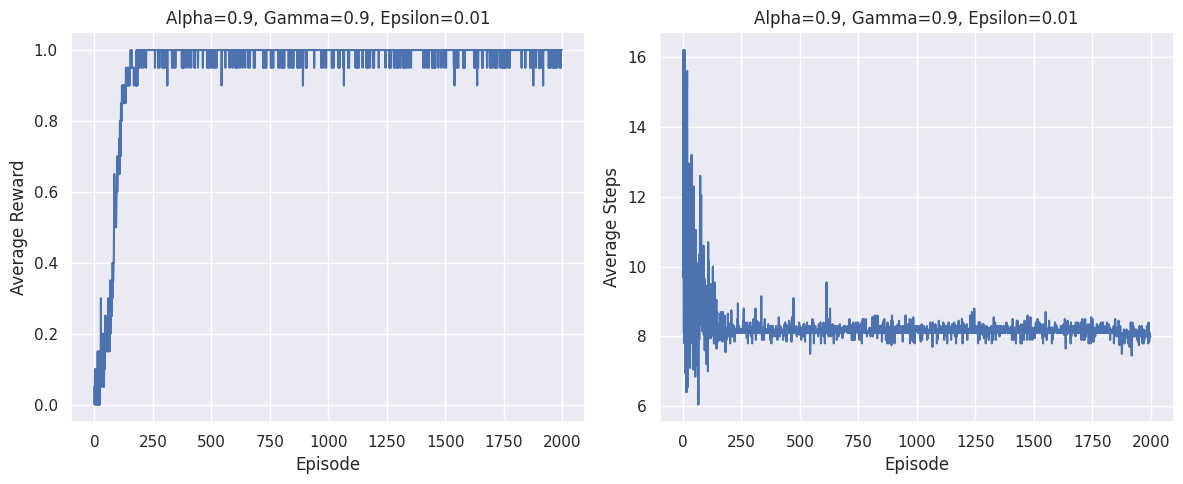

Running with alpha=0.9, gamma=0.9, epsilon=0.1


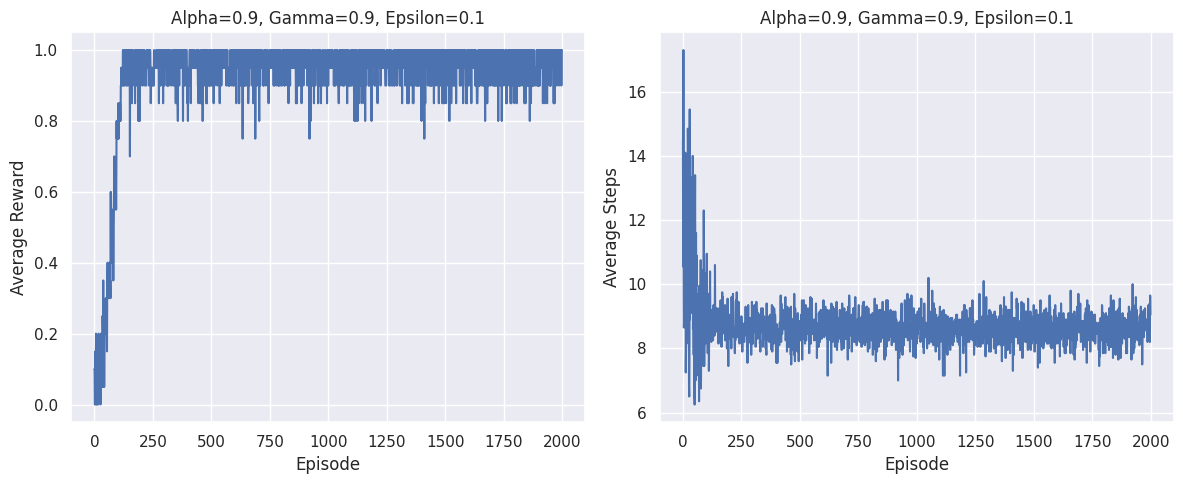

Running with alpha=0.9, gamma=0.9, epsilon=0.5


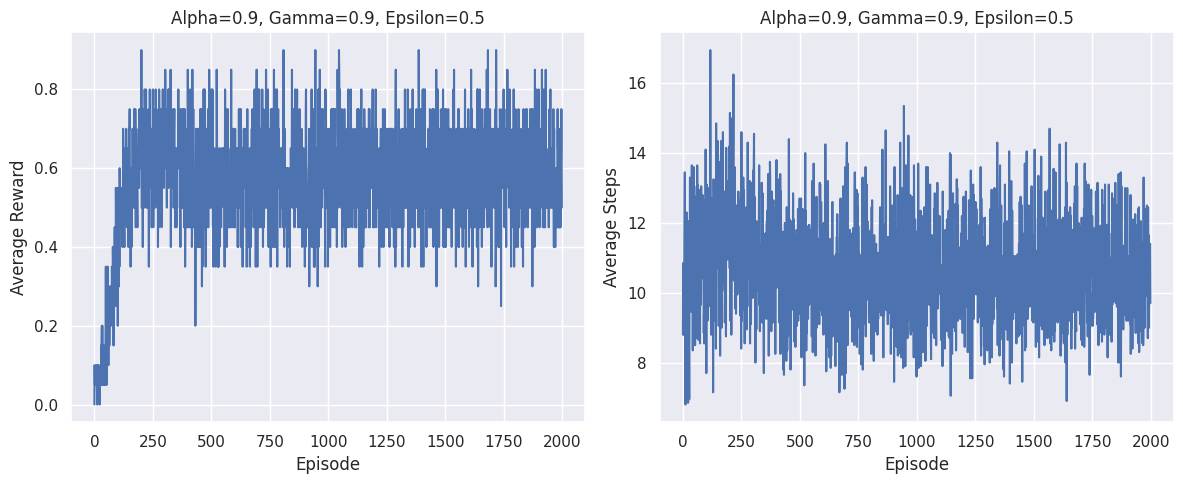

Running with alpha=0.9, gamma=0.99, epsilon=0.01


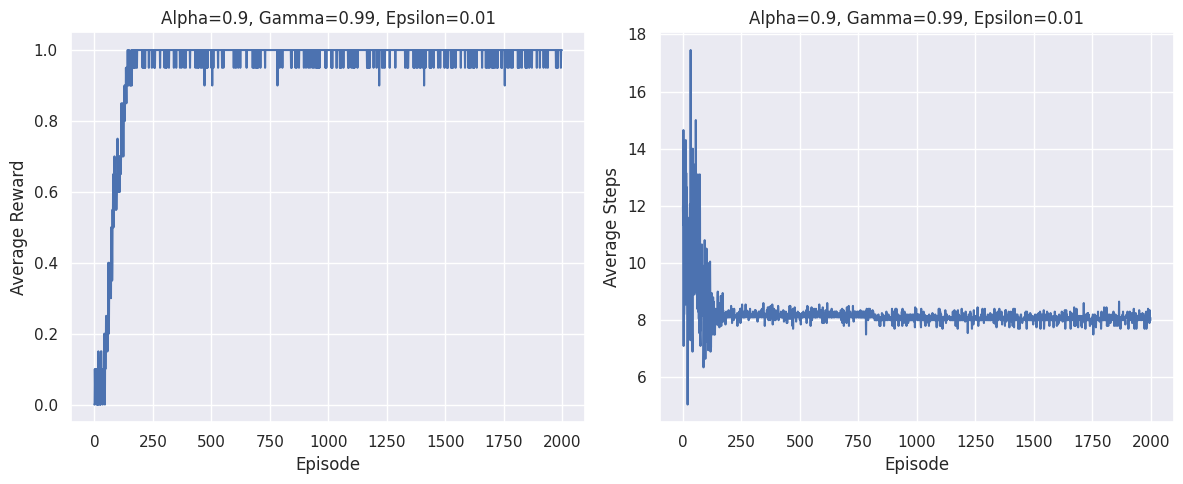

Running with alpha=0.9, gamma=0.99, epsilon=0.1


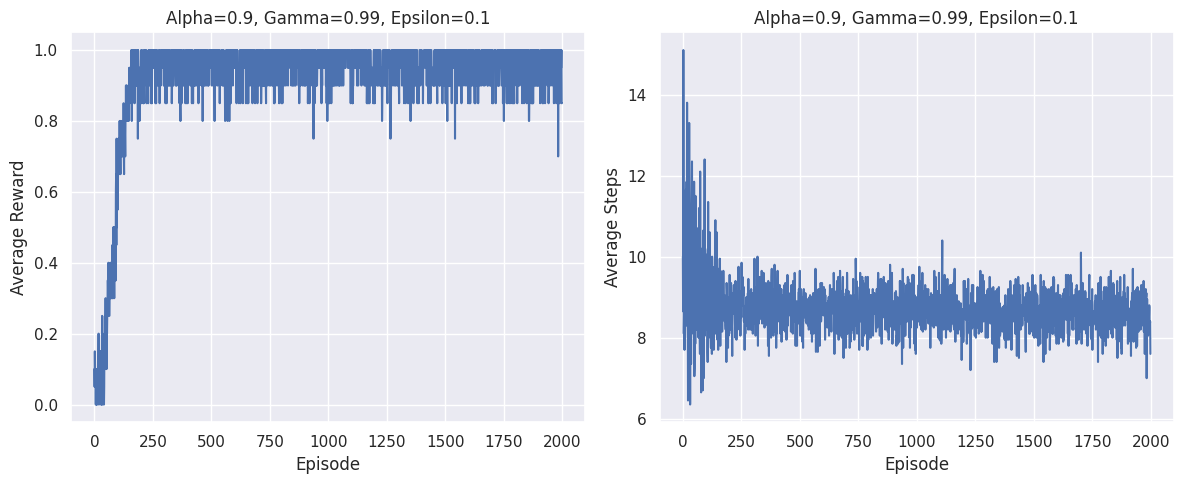

Running with alpha=0.9, gamma=0.99, epsilon=0.5


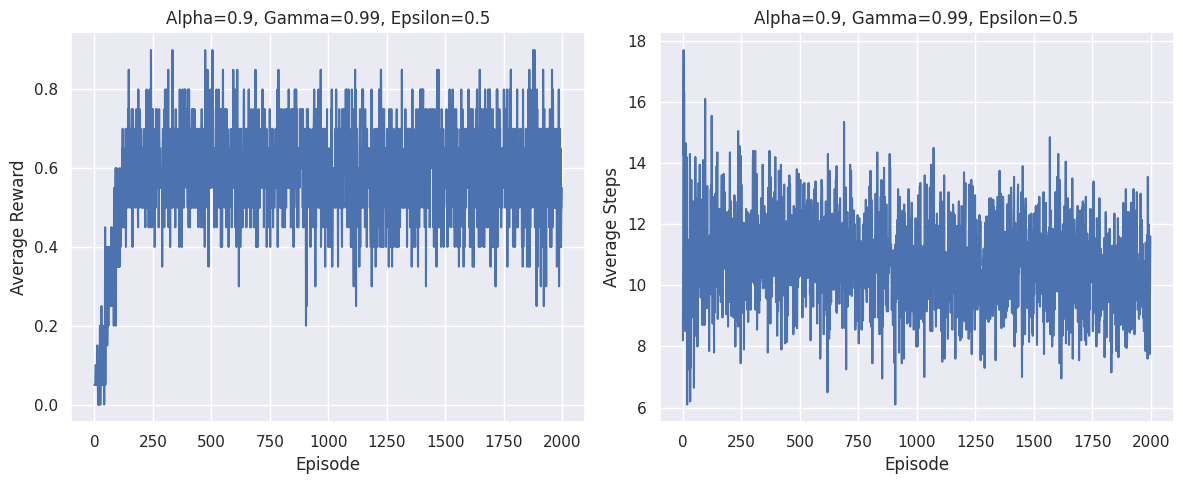

In [ ]:
alphas = [0.1, 0.5, 0.9]
gammas = [0.8, 0.9, 0.99]
epsilons = [0.01, 0.1, 0.5]

results = {}

for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            print(f"Running with alpha={alpha}, gamma={gamma}, epsilon={epsilon}")

            learner = Qlearning(learning_rate=alpha, gamma=gamma, state_size=params.state_size, action_size=params.action_size)
            explorer = EpsilonGreedy(epsilon=epsilon)

            rewards, steps, episodes, qtables, all_states, all_actions = run_env(alpha, gamma, epsilon)

            results[(alpha, gamma, epsilon)] = {
                'rewards': rewards,
                'steps': steps,
            }

            avg_rewards = rewards.mean(axis=1)  # average rewards per episode
            avg_steps = steps.mean(axis=1)  # average steps per episode

            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(episodes, avg_rewards)
            plt.xlabel("Episode")
            plt.ylabel("Average Reward")
            plt.title(f"Alpha={alpha}, Gamma={gamma}, Epsilon={epsilon}")

            plt.subplot(1, 2, 2)
            plt.plot(episodes, avg_steps)
            plt.xlabel("Episode")
            plt.ylabel("Average Steps")
            plt.title(f"Alpha={alpha}, Gamma={gamma}, Epsilon={epsilon}")

            plt.tight_layout()
            plt.show()

In [ ]:
def policy_evaluation(policy, env, gamma, theta=1e-6):
    V = np.zeros(env.observation_space.n)
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            v = V[s]
            V[s] = sum(
                [
                    env.P[s][a][0][0]
                    * (env.P[s][a][0][2] + gamma * V[env.P[s][a][0][1]])
                    for a in range(env.action_space.n)
                ]
            )
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V

def policy_improvement(env, gamma, V):
    policy = np.zeros(env.observation_space.n)
    for s in range(env.observation_space.n):
        action_values = [
            sum(
                [
                    env.P[s][a][0][0]
                    * (env.P[s][a][0][2] + gamma * V[env.P[s][a][0][1]])
                ]
            )
            for a in range(env.action_space.n)
        ]
        policy[s] = np.argmax(action_values)
    return policy

def policy_iteration(env, gamma):
    policy = np.zeros(env.observation_space.n)
    while True:
        V = policy_evaluation(policy, env, gamma)
        new_policy = policy_improvement(env, gamma, V)
        if np.array_equal(policy, new_policy):
            break
        policy = new_policy
    return policy, V

In [18]:
env_without_time_limit = env.unwrapped
policy, V = policy_iteration(env_without_time_limit, gamma=0.95)

def run_policy(env, policy, num_episodes=1000):
    total_rewards = []
    total_steps = []
    for episode in range(num_episodes):
        state = env.reset(seed=params.seed)[0]
        done = False
        episode_reward = 0
        episode_steps = 0

        while not done:
            action = int(policy[state])  # choose action according to policy
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            episode_steps += 1
            state = next_state
            done = terminated or truncated

        total_rewards.append(episode_reward)
        total_steps.append(episode_steps)

    return total_rewards, total_steps


policy_rewards, policy_steps = run_policy(env, policy)
avg_policy_reward = np.mean(policy_rewards)
avg_policy_steps = np.mean(policy_steps)

print(f"Policy Iteration - Average Reward: {avg_policy_reward}, Average Steps: {avg_policy_steps}")

for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            print(f"Running with alpha={alpha}, gamma={gamma}, epsilon={epsilon}")

            learner = Qlearning(learning_rate=alpha, gamma=gamma, state_size=params.state_size, action_size=params.action_size)
            explorer = EpsilonGreedy(epsilon=epsilon)

            rewards, steps, episodes, qtables, all_states, all_actions = run_env(alpha, gamma, epsilon)

            results[(alpha, gamma, epsilon)] = {
                'rewards': rewards,
                'steps': steps,
            }


best_qlearning_result = max(results, key=lambda k: np.mean(results[k]['rewards']))
avg_qlearning_reward = np.mean(results[best_qlearning_result]['rewards'])
avg_qlearning_steps = np.mean(results[best_qlearning_result]['steps'])

print(f"Q-learning (best) - Average Reward: {avg_qlearning_reward}, Average Steps: {avg_qlearning_steps}")

<ipython-input-1-6486d30a5341>:7: RuntimeWarning: overflow encountered in scalar add
  V[s] = sum(
<ipython-input-1-6486d30a5341>:14: RuntimeWarning: invalid value encountered in scalar subtract
  delta = max(delta, abs(v - V[s]))


Policy Iteration - Average Reward: 0.0, Average Steps: 100.0
Running with alpha=0.1, gamma=0.8, epsilon=0.01


Running with alpha=0.1, gamma=0.8, epsilon=0.1


Running with alpha=0.1, gamma=0.8, epsilon=0.5


Running with alpha=0.1, gamma=0.9, epsilon=0.01


Running with alpha=0.1, gamma=0.9, epsilon=0.1


Running with alpha=0.1, gamma=0.9, epsilon=0.5


Running with alpha=0.1, gamma=0.99, epsilon=0.01


Running with alpha=0.1, gamma=0.99, epsilon=0.1


Running with alpha=0.1, gamma=0.99, epsilon=0.5


Running with alpha=0.5, gamma=0.8, epsilon=0.01


Running with alpha=0.5, gamma=0.8, epsilon=0.1


Running with alpha=0.5, gamma=0.8, epsilon=0.5


Running with alpha=0.5, gamma=0.9, epsilon=0.01


Running with alpha=0.5, gamma=0.9, epsilon=0.1


Running with alpha=0.5, gamma=0.9, epsilon=0.5


Running with alpha=0.5, gamma=0.99, epsilon=0.01


Running with alpha=0.5, gamma=0.99, epsilon=0.1


Running with alpha=0.5, gamma=0.99, epsilon=0.5


Running with alpha=0.9, gamma=0.8, epsilon=0.01


Running with alpha=0.9, gamma=0.8, epsilon=0.1


Running with alpha=0.9, gamma=0.8, epsilon=0.5


Running with alpha=0.9, gamma=0.9, epsilon=0.01


Running with alpha=0.9, gamma=0.9, epsilon=0.1


Running with alpha=0.9, gamma=0.9, epsilon=0.5


Running with alpha=0.9, gamma=0.99, epsilon=0.01


Running with alpha=0.9, gamma=0.99, epsilon=0.1


Running with alpha=0.9, gamma=0.99, epsilon=0.5


Q-learning (best) - Average Reward: 0.958875, Average Steps: 8.15055
